Dataset yang digunakan adalah PRDECT-ID dari Kaggle, yang berisi ulasan produk dalam bahasa Indonesia yang dilengkapi dengan label emosi dan sentimen. Data mencakup kategori produk, nama produk, lokasi, harga, rating, jumlah terjual, dan ulasan teks pelanggan. Setiap ulasan diberi label sentimen (Positive/Negative) serta emosi (seperti Happy, Sad, dll).

Dalam proyek ini, fokusnya adalah pada klasifikasi sentimen untuk memprediksi apakah ulasan tersebut bersifat positif atau negatif.

In [197]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

In [198]:
df = pd.read_csv("PRDECT-ID Dataset.csv")

In [199]:
df.shape

(5400, 11)

In [200]:
# baca isi data
df[['Customer Review', 'Sentiment']].head()

,Customer Review,Sentiment
0,Alhamdulillah berfungsi dengan baik. Packaging...,Positive
1,"barang bagus dan respon cepat, harga bersaing ...",Positive
2,"barang bagus, berfungsi dengan baik, seler ram...",Positive
3,bagus sesuai harapan penjual nya juga ramah. t...,Positive
4,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive


In [201]:
df['Sentiment'].unique()

array(['Positive', 'Negative'], dtype=object)

In [202]:
# cek nilai null
df[['Customer Review', 'Sentiment']].isna().sum()

,0
Customer Review,0
Sentiment,0


In [203]:
# cek nilai duplikat
df.duplicated().sum()

np.int64(7)

In [204]:
# cek apakah customer review mengandung emoji, html tags, atau url
emoji = r":-?\)|:-?\(|:-?P|:-?D|:\]|:\["
html = r"<.*?>"
url = r"https?://\S+|www\.\S+"

emoji_count = df['Customer Review'].str.contains(emoji, regex=True, na=False).sum()
html_count = df['Customer Review'].str.contains(html, regex=True, na=False).sum()
url_count = df['Customer Review'].str.contains(url, regex=True, na=False).sum()

print(f"emoji count : {emoji_count}")
print(f"html tags count : {html_count}")
print(f"urls count : {url_count}")


emoji count : 60
html tags count : 0
urls count : 1


In [205]:
# kamus emoji (diganti dgn kata yg merepresentasikan emosi)
emoji_dict = {
    r":-?\)": "senang",
    r":-?D": "senang",
    r":-?P": "senang",
    r":-?\(": "sedih",
    r":-\[": "sedih",
    r":-\|": "netral",
    r":\)": "senang",
    r":\(": "sedih"
}

# ***preprocessing***

In [206]:
# membersihkan nilai duplikat
df = df.drop_duplicates()

# ambil stopwords bahasa indonesia
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

# ganti emoji dgn teks
def replace_emoji(text):
    for emoji, meaning in emoji_dict.items():
        text = re.sub(emoji, meaning, text)
    return text

# membersihkan teks
def clean_text(text):
    text = replace_emoji(text)
    text = text.lower() # lowercase
    text = re.sub(r"<.*?>", "", text)  # hapus html
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # hapus angka & simbol
    text = " ".join([word for word in text.split() if word not in stop_words]) # hapus stopwords
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [207]:
# pembersihan teks pd kolom customer review
df['Review'] = df['Customer Review'].apply(clean_text)

<ipython-input-207-8f69dbf51439>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Review'] = df['Customer Review'].apply(clean_text)


# ***pemodelan machine learning dengan Random Forest***

In [208]:
X = df['Review'] # fitur input
y = df['Sentiment'] # label target

In [209]:
# encode label data kategorikal ke numerik
le = LabelEncoder()
y = le.fit_transform(y)  # positive = 1, negative = 0

In [210]:
# split data jadi 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [211]:
# ubah ke vektor TF-IDF (teks diubah ke angka agar dpt diproses model)
tfidf = TfidfVectorizer()
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

In [212]:
# train model Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_vec, y_train)

RandomForestClassifier(random_state=42)

# ***evaluasi model***

In [213]:
y_pred = model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.8906056860321384

Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.88      0.89       841
    Positive       0.88      0.90      0.89       777

    accuracy                           0.89      1618
   macro avg       0.89      0.89      0.89      1618
weighted avg       0.89      0.89      0.89      1618



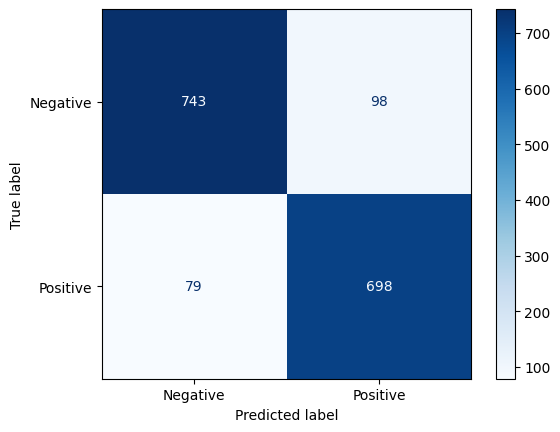

In [214]:
# visualisasi confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test_vec, y_test, display_labels=le.classes_, cmap='Blues')

# ***prediksi ulasan baru***

In [221]:
# prediksi dgn data input baru
sample_texts = [
    'pengiriman cepat, produk sesuai dan kualitas oke :)',
    'barang datang rusak, sangat mengecewakan :(',
    'harganya lumayan mahal tapi sesuai dengan kualitas'
]

In [220]:
# bersihkan dan proses teks seperti data training
cleaned_samples = [clean_text(text) for text in sample_texts]

# ubah ke vektor TF-IDF
vectorized_samples = tfidf.transform(cleaned_samples)

# prediksi
sample_preds = model.predict(vectorized_samples)

# ubah label ke bentuk aslinya (positive/negative)
predicted_labels = le.inverse_transform(sample_preds)

# tampilkan hasil
for i, text in enumerate(sample_texts):
    print(f"teks : {text}")
    print(f"prediksi sentimen : {predicted_labels[i]}\n")

teks : pengiriman cepat, produk sesuai dan kualitas oke :)
prediksi sentimen : Positive

teks : barang datang rusak, sangat mengecewakan :(
prediksi sentimen : Negative

teks : harganya lumayan mahal tapi sesuai dengan kualitas :(
prediksi sentimen : Positive

